## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib notebook

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [19]:
import model

## Simulation mechanics

In [37]:
def c_bound(z: float, k: float, p:dict):
    """Upper bound on the amount that can be consumed
    
    .. math:: c_t \leq z_t\cdotk_t\cdot\alpha^{-\frac{1}{\mu}}
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    return z * k * p['alpha'] ** (-1 / p['mu'])


def bisection(z:float, g:float, k:float, p:dict, precision:float=1e-5):
    """ Determine the level of consumption using the bisection method
    
    .. math:: \frac{2\gamma}{1-\alpha} c_t -  G_t z_t \left(c_t^{-\mu } z_t^{\mu }\right)^{-\frac{\mu +1}{\mu }} \left(\frac{c_t^{-\mu } z_t^{\mu }-\alpha  k_t^{-\mu }}{1-\alpha }\right)^{\frac{2}{\mu }+1} = 0
    
    
    Parameters
    ----------
    z : float
        Level of productivity
    g : float
        Consumption rate (% of income consumed)
    k : float
        Level of capital at t
    p : dict
        Parameters from simulation
    precision : float, default: 1e-5
        Precision of the bisection solution
    
    Returns
    -------
    c : float
        level of consumption
    """
    
    # Pre-compute constants
    mu = p['mu']
    lhs_1 = 2 * p['gamma'] / (1 - p['alpha'])
    rhs_1 = g * z / ((1 - p['alpha']) ** (2 / mu + 1))
    rhs_2 = p['alpha'] * k ** (-1 * mu)
    
    # Minimisation target for the bisection
    def diff(c: float):
        r = z / c
        rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
        return c * lhs_1 - rhs
    
    max_val = c_bound(z, k, p)
    
    # Adapt by precision to avoid asymptotic bounds
    x = [precision, max_val / 2, max_val-precision]
    abs_lst = [abs(diff(i)) for i in x[:2]]

    while min(abs_lst) >= precision:
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]

In [87]:
def step(t: float, x: np.ndarray, p: dict):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Starting variables
    z_, c_, n_, b_, w_, k_, q_, g_, s_, news_, inc_, xiz_, xin_ = x
        
    # Random technology process
    rand = np.random.normal(0, p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)
    
    # Observe "State of economy"
    g = g_
    s = s_
    #g = 0.5 * (p['g_max'] + p['g_min'] - news * (p['g_max'] - p['g_min']))
    #s = 0.5 * (p['s_max'] + p['s_min'] - news * (p['s_max'] - p['s_min']))
    
    # "Shocks"
    #if all([t > 100, t< 300]):
    #    g = 0.2
    #if t > 300:
    #    g = 0.8
    
    # Given capital(t-1), consumption-rate(t), productivity(t)
    c = bisection(z, g, k_, p)
    
    # Observing wages(t-1), given c(t), HH determines working hours
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes labour, Capital, Production -> sets factor prices
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
    
    # Income
    income = w * n + (b_  + q_ * k_) / (1 + p['inflation'])
    
    # Investment & Bonds
    investment = income * (1 - g)
    b = (1 + p['interest']) * s * investment
    
    # Capital & Risky return
    k = (1 - p['depreciation']) * k_ + investment * (1 - s)
    q = p['alpha'] * z * temp * (k ** (rho - 1))
    
    # Retain previous news formula out of interest
    xin = np.random.normal(0, p['sigmaN'])
    info = p['n_cons']*(c/c_ - 1)
    step_news = p['n_persistence'] * news_ + (1 - p['n_persistence']) * info + xin
    news = np.tanh(p['n_theta'] * step_news)

    return z, c, n, b, w, k, q, g, s, news, income, xiz, xin

In [79]:
def simulate(start: np.ndarray, p: dict, t_end: float = 1e3):
    x = np.empty((int(t_end), len(start)))
    x[0, :] = start
    for t in range(1, int(t_end)):
        x[t, :] = step(t, x[t - 1, :], p)
    cols = ['z', 'c', 'n', 'b', 'w', 'k', 'q', 'g', 's', 'news', 'income', 'xiz', 'xin']
    df = pd.DataFrame(x, columns=cols)
    df.loc[:,'inv'] = 100*(1-df.loc[:,'g'])
    df.loc[:,'bc'] = df.b / df.c
    return df

----
## Interactive Analysis

<IPython.core.display.Javascript object>


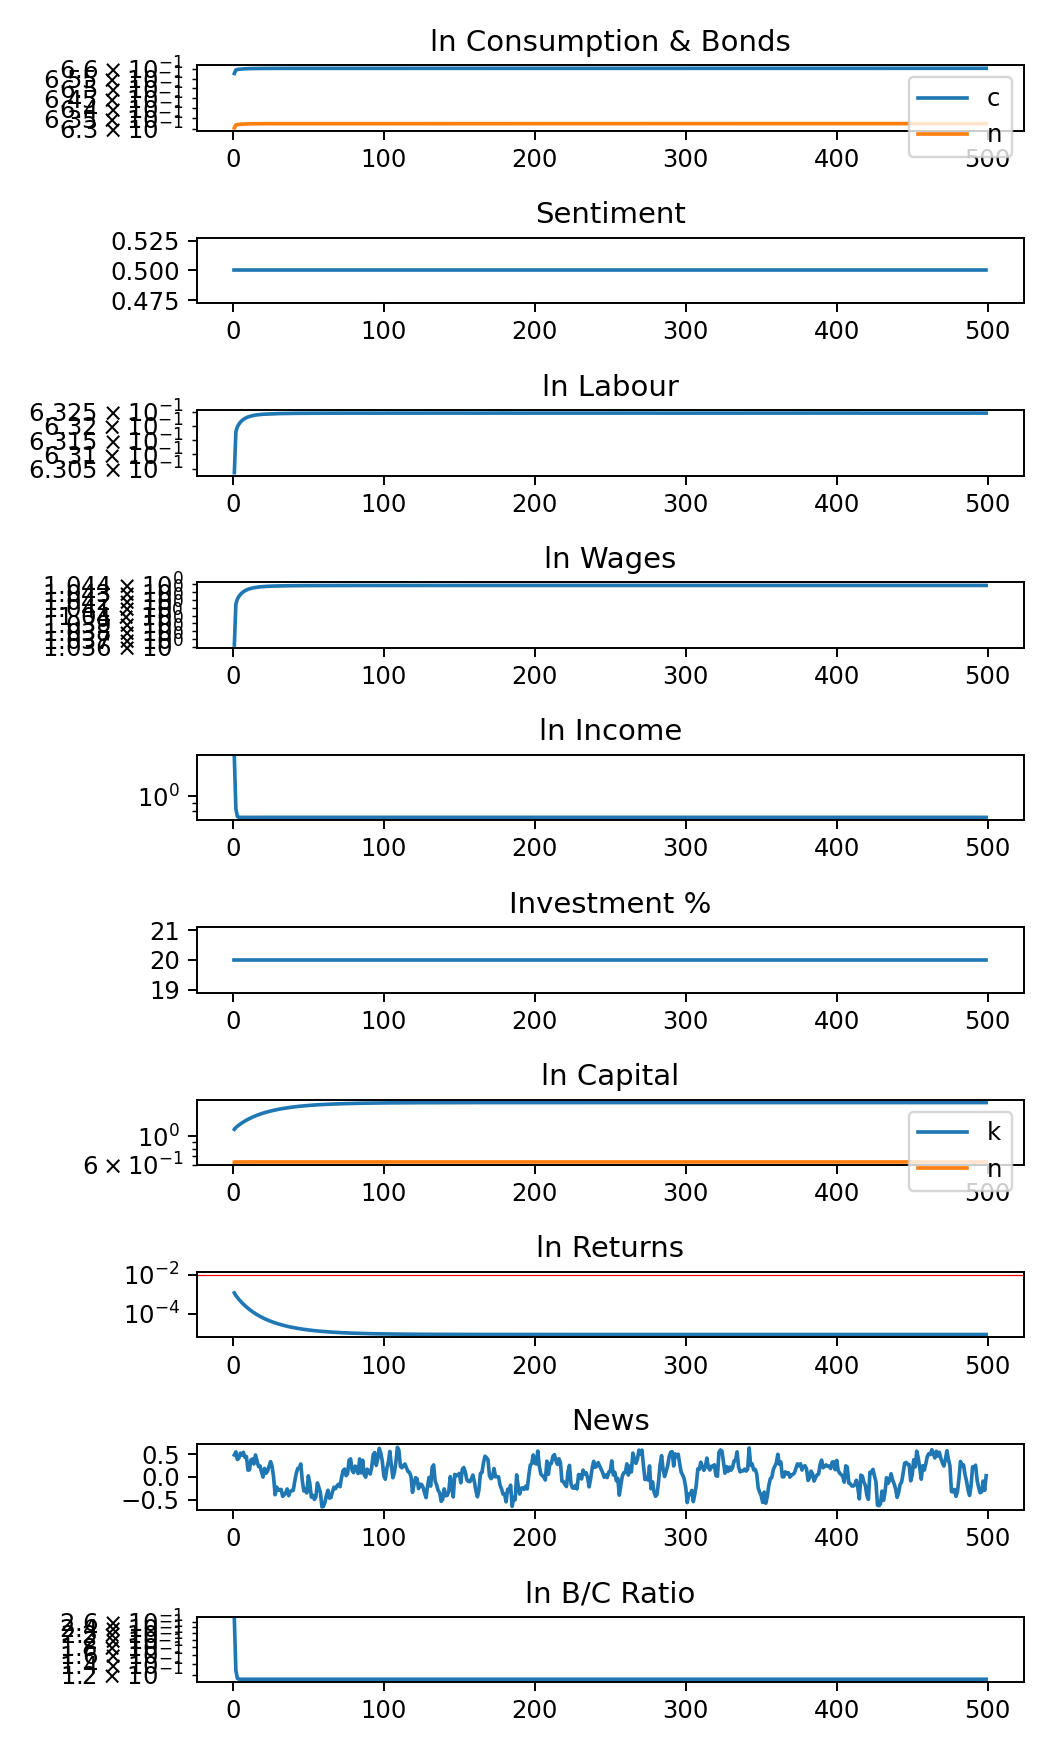

In [90]:
params = {'etaZ': 0.2, 'sigmaZ': 0.0, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.04, 
          'g_min': 0.9, 'g_max': 1-1e-4, 's_min': 0.5, 's_max': 2, 
          'n_cons': 10, 'n_theta': 1, 'n_persistence': 0.9, 
          'gamma': 1.0, 'alpha': 0.33, 'mu': 9.32}

start = dict(z=1, c=1, n=1, b=1, w=1, k=1, q=0.1, g=0.8, s=0.5, income=1, news=1, xiz=0, xin=0)
start = np.array([v for _,v in start.items()])

T = 5e2
np.random.seed(40)
view = (1, int(T))


df = simulate(start, params, T)
df = df.iloc[view[0]:view[1],:]

graphs = {
        'ln Consumption & Bonds' : [df.loc[:,['c','n']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.n, True],
        'ln Wages' : [df.w, True],
        'ln Income' : [df.income, True],
        'Investment %' : [df.inv, False],
        'ln Capital' : [df.loc[:,['k','n']], True],
        'ln Returns' : [df.q, True],
        'News' : [df.news, False],
        'ln B/C Ratio' : [df.bc, True],
    }


axs = model.simulation_graph(graphs, size = (6, 10))
axs['ln Returns'].axhline(params['interest'], color='red', linewidth=0.5)
#plt.savefig('/Users/fedemoro/Desktop/test.pdf',format = 'pdf')

---
## Solution Analysis

In [127]:
param_bounds = {
    # Restrict noise params to be constant
    'etaZ': (0.2,0.2), 'sigmaZ': (0.8,0.8), 'sigmaN': (0.2,0.2), 
    # Realistic monthly values - 0% to 5%
    'inflation': (0.0,0.05), 'interest': (0.0,0.05), 'depreciation': (0.0,0.05),
    # Saving and bond parameters
    'g_min': (0.0,0.99), 'g_max': (0.0,0.99), 'f_min': (0.0,1e1), 'f_max': (1e1,1e3),
    # News parameters
    'n_cons': (0.1,10), 'n_theta': (0.1,10), 'n_persistence': (0.0,0.99),
    # Production & Household
    'zbar': (1.0,1.0), 'gamma': (1.0,10.0), 'alpha': (0.1,0.9), 'rho': (-1e4,-1e-1), 
    # No shocks for now
    'shock': (0.0,0.0)}

n = 5
param_steps = {'etaZ': 0, 'sigmaZ': 0, 'sigmaN': 0, 'inflation': 0, 'interest': 0, 'depreciation': 0,
    'g_min': n, 'g_max': n, 'f_min': n, 'f_max': n, 'n_cons': n, 'n_theta': n, 'n_persistence': n,
    'zbar': 0, 'gamma': 0, 'alpha': n, 'rho': n, 'shock': 0}

In [119]:
# Generate the whole set of parameters
params = {'etaZ': 0.2, 'sigmaZ': 0.8, 'zbar': 1.0, 'sigmaN': 0.2, 
          'inflation': 0.01, 'interest': 0.01, 'depreciation': 0.01, 
          'g_min': 0.8, 'g_max': 0.99, 'f_min': 1.0, 'f_max': 100, 
          'n_cons': 1, 'n_theta': 1, 'n_persistence': 0.8, 
          'gamma': 1.0, 'alpha': 0.5, 'rho': -1, 'shock': 0.0}

constants = [k for k,v in param_steps.items() if v==0]
ranges = {k:np.linspace(*v, param_steps[k]) for k,v in param_bounds.items()}
ranges = {k:v for k,v in ranges.items() if v.size!=0}

In [10]:
results = pd.DataFrame(columns = list(ranges.keys()))

In [11]:
from itertools import product

var = list(ranges.keys())

for tup in product(*list(ranges.values())):
    # Generate unique parameter set
    p = dict(params)
    for combo in zip(var, tup):
        p[combo[0]] = combo[1]
    #df = simulate(start)


In [12]:
def dead_economy(df, epsilon):
    return df.c.iloc[-1] < epsilon

In [23]:
# CES
def lhs_CES(cons: float, z: float, k:float, alpha: float, gamma: float, r: float, rho: float) -> float:
        pt1 = 2 * gamma * (1+r) / ((z ** 2) * (1 - alpha) ** (2 / rho))
        pt2 = cons ** 2
        pt3 = (1 - alpha*(z * k / cons) ** rho) ** ((2 - rho) / rho)
        print(pt1, pt2, pt3)
        return pt1 * pt2 * pt3

def rhs_CES(cons: float, gti: float, ft: float) -> float:
    return 1 - (ft * cons) / (gti - cons)
    

def bisection_CES(z:float, income:float, k:float, gt_:float, ft_:float, p:dict, err:float=1e-2)->float:
    assert gt_ * income > 0
    # Define the left and right hand sides of the equations
    diff = lambda c: rhs_CES(c, gt_ * income, ft_) - lhs_CES(c, z, k, p['alpha'], p['gamma'], p['interest'], p['rho'])
    
    # Initial guess at the next options for 
    a = k * z * (p['alpha'] ** (1 / p['rho'])) 
    if a > gt_ * income:
        print("Bad boundaries, setting c=g")
        return gt_ * income
    
    x = [a, 0.5 * (gt_*income + a), gt_*income]
    print(x)
    
    #guess = np.min([gt_*income, k * z * (p['alpha'] ** (1 / p['rho']))])
    #x = [0, guess / 2, guess]
    abs_lst = [abs(diff(i)) for i in x[:2]]
    
    # Apply bi-section method
    while min(abs_lst) >= err:
        test = np.sign([diff(i) for i in x])
        if test[0] == test[1]:
            x = [x[1], (x[1] + x[2]) / 2, x[2]]
        elif test[1] == test[2]:
            x = [x[0], (x[0] + x[1]) / 2, x[1]]

        abs_lst = [abs(diff(i)) for i in x[:2]]

    return x[np.argmin(abs_lst)]